# Projet Data Camp

This project can be found at "./datacamp.pdf". The aim is to find a way to maximize the "cells" size eaten at specific location within a limited range of time.

## Preprocessing

In this section, we will import, open data and manage to explore and maybe reorganize them.

### Imports

In [92]:
# Datascience libraries
import pandas as pd
import numpy as np

# basic python libraries
import math
import time

# plot
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 16, 10

### Opening Data

In [75]:
#Parser de fichiers
df = pd.read_csv("data.txt",header=None)
df.head()

,0,1,2,3
0,0,-11.03,-82.33,46
1,1,-4.93,-98.05,96
2,2,81.52,2.41,49
3,3,36.82,-42.62,71
4,4,-69.86,11.88,27


### Exploring Data

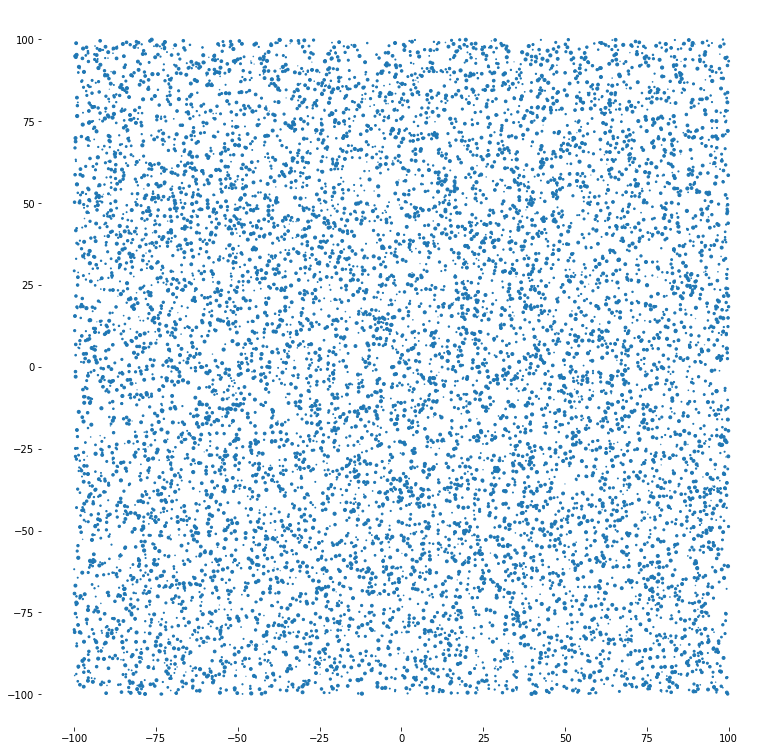

In [76]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1], frameon=False, aspect=1)
scat = ax.scatter(df.iloc[:,1], df.iloc[:,2],s=0.1*df.iloc[:,3])

--> distributed in a uniform way

## Strategy

In this section, we will implements differents strategies in order to achieve our goal.

### Defining Game

In [77]:
class Game(object):
    
    def __init__(self, time):
        super(Game, self).__init__()
        self._const_time = time
    
    # init a game and reset it
    def init_game(self, M, init_coord):
        self._Values = M[:,1:]
        self._Ids = M[:, 0].astype(int)
        self.actual_coord = init_coord
        self.ids = []
        self.rewards = []
        self.time = 0.
        # first step
        possibilities = self._Values[:,:2]
        rewards = self._Values[:,2]
        return False, False, possibilities, rewards, self._const_time - self.time, self.actual_coord
        
    # step in a game
    def step_env(self, action, distance):
        # check if there is a correct action or not
        if action == -1:
            return True, False, None, None, self._const_time - self.time, None
        else:
            # get reward
            reward = self._Values[action, 2]
            self._Values[action, 2] = 0.

            # keep track of action
            self.ids.append(self._Ids[action])
            self.rewards.append(reward)

            # update time and coordinate
            self.time += distance
            self.actual_coord = (self._Values[action, 0], self._Values[action, 1])

            # step into the environnement
            if self.time < self._const_time:
                possibilities = self._Values[:,:2]
                rewards = self._Values[:,2]
                return False, False, possibilities, rewards, self._const_time - self.time, self.actual_coord
            else:
                # previous time was not correctly endled by the agent(strategy)
                return False, True, None, None, self._const_time - self.time, None
    
        
    
    # string representation of the object
    def __repr__(self):
        return "<Object : Game (DataCamp) <> time:{}>".format(self._const_time)
    def __str__(self):
        return self.__repr__()

### Defining strategies

In [78]:
class Strategy(object):
    
    def __init__(self):
        super(Strategy, self).__init__()
    
    def choose_action(self, possibilities, rewards, time_left, coordinate):
        return None
        
    # string representation of the object
    def __repr__(self):
        return "<Object : Strategy (DataCamp)>"
    def __str__(self):
        return self.__repr__()

#### Naive Approach

This strategy will use a greedy approach, selecting the max value following a defined metric at each steps.

Metrics will be defined under.

In [79]:
class Naive_Metric_Strategy(Strategy):
    
    def __init__(self, metric):
        super(Naive_Metric_Strategy, self).__init__()
        self.metric = metric
        
    def choose_action(self, possibilities, rewards, time_left, coordinate):
        distances = np.zeros((possibilities.shape[0],))
        for point in range(possibilities.shape[0]):
            distances[point] = math.sqrt((coordinate[0]- possibilities[point,0])**2 + (coordinate[1] - possibilities[point,1])**2)
        ratios = self.metric.apply(distances, rewards)
        action = self.metric.choose(distances, ratios, time_left)
        return action, distances[action]
        
    # string representation of the object
    def __repr__(self):
        return "<Object : Strategy (DataCamp) <> Naive_Metric_Strategy>"
    def __str__(self):
        return self.__repr__()

defining the metric object

In [80]:
class Metric(object):
    def __init__(self):
        super(Metric, self).__init__()
        
    def apply(self, distances, rewards):
        return None
    
    def choose(self, distances, ratios, time_left):
        target_pos = np.argmax(ratios)
        if time_left - distances[target_pos] < 0:
            # the metrics can't find a cell to eat in the given left time
            return -1
        else:
            return target_pos
    
    # string representation of the object
    def __repr__(self):
        return "<Object : Metric (DataCamp)>"
    def __str__(self):
        return "Metric"

Defining the metrics

In [162]:
class Euclidean_1_Metric(Metric):
    def __init__(self):
        super(Euclidean_1_Metric, self).__init__()
        
    def apply(self, distances, rewards):
        euclidean_ratios = np.array([(rewards[i] / distances[i]) if distances[i] != 0. else 0. for i in range(distances.shape[0])])
        return euclidean_ratios
    
class Euclidean_2_Metric(Metric):
    def __init__(self):
        super(Euclidean_2_Metric, self).__init__()
        
    def apply(self, distances, rewards):
        euclidean_ratios = np.array([( (rewards[i] - math.sqrt(distances[i])) / distances[i] ) if distances[i] != 0. else 0. for i in range(distances.shape[0])])
        return euclidean_ratios
    
class Euclidean_3_Metric(Metric):
    def __init__(self):
        super(Euclidean_3_Metric, self).__init__()
        
    def apply(self, distances, rewards):
        dist_scaled = (distances - distances.min()) / (distances.max() - distances.min())
        euclidean_ratios = np.array([( (1-dist_scaled[i])*rewards[i] ) if distances[i] != 0. else 0. for i in range(distances.shape[0])])
        return euclidean_ratios
    
class Euclidean_4_Metric(Metric):
    def __init__(self):
        super(Euclidean_4_Metric, self).__init__()
        
    def apply(self, distances, rewards):
        dist_scaled = (distances - distances.min()) / (distances.max() - distances.min())
        euclidean_ratios = np.array([( (1-dist_scaled[i])*rewards[i] / distances[i] ) if distances[i] != 0. else 0. for i in range(distances.shape[0])])
        return euclidean_ratios
    
class Euclidean_5_Metric(Metric):
    def __init__(self):
        super(Euclidean_5_Metric, self).__init__()
        
    def apply(self, distances, rewards):
        euclidean_ratios = np.array([( (rewards[i] - distances[i]**2) / distances[i] ) if distances[i] != 0. and rewards[i] != 0. else 0. for i in range(distances.shape[0])])
        mini = np.min(euclidean_ratios)
        if mini < 0.:
            for i in range(euclidean_ratios.shape[0]):
                if euclidean_ratios[i] != 0.:
                    euclidean_ratios[i] -= (mini - 1)
        return euclidean_ratios
    
class Euclidean_6_Metric(Metric):
    def __init__(self):
        super(Euclidean_6_Metric, self).__init__()
        
    def apply(self, distances, rewards):
        euclidean_ratios = np.array([( (math.sqrt(rewards[i]) - math.sqrt(distances[i])) / distances[i] ) if distances[i] != 0. and rewards[i] != 0. else 0. for i in range(distances.shape[0])])
        mini = np.min(euclidean_ratios)
        if mini < 0.:
            for i in range(euclidean_ratios.shape[0]):
                if euclidean_ratios[i] != 0.:
                    euclidean_ratios[i] -= (mini - 1)
        return euclidean_ratios
    
class Euclidean_7_Metric(Metric):
    def __init__(self):
        super(Euclidean_7_Metric, self).__init__()
        
    def apply(self, distances, rewards):
        euclidean_ratios = np.zeros((rewards.shape[0]))
        for i in range(distances.shape[0]):
            if distances[i] != 0. and rewards[i] != 0.:
                temp = (math.sqrt(rewards[i]) - math.sqrt(distances[i]))
                temp = temp**2 * -1 if temp < 0 else 1
                euclidean_ratios[i] = ( temp / distances[i] )
        mini = np.min(euclidean_ratios)
        if mini < 0.:
            for i in range(euclidean_ratios.shape[0]):
                if euclidean_ratios[i] != 0.:
                    euclidean_ratios[i] -= (mini - 1)
        return euclidean_ratios
    
class Euclidean_8_Metric(Metric):
    def __init__(self):
        super(Euclidean_8_Metric, self).__init__()
        
    def apply(self, distances, rewards):
        euclidean_ratios = np.array([( (math.log(rewards[i]) - math.log(distances[i])) / distances[i] ) if distances[i] != 0. and rewards[i] != 0. else 0. for i in range(distances.shape[0])])
        mini = np.min(euclidean_ratios)
        if mini < 0.:
            for i in range(euclidean_ratios.shape[0]):
                if euclidean_ratios[i] != 0.:
                    euclidean_ratios[i] -= (mini - 1)
        return euclidean_ratios

In [123]:
def play_game(M, strategy, max_time, init_coord, epochs=1):
    game = Game(max_time)
    
    for i in range(epochs):
        # reset env
        game_correctly_ended, game_bug_ended, possibilities, rewards, time_left, coordinates = game.init_game(M, init_coord)
        _action = None
        # stepping in the environnement
        while((not game_correctly_ended) and (not game_bug_ended)):
            # the agent choose the following action
            action, distance = strategy.choose_action(possibilities, rewards, time_left, coordinates)
            if _action != None and _action == action:
                print("bug")
            # step
            game_correctly_ended, game_bug_ended, possibilities, rewards, time_left, coordinates = game.step_env(action, distance)
            _action=action
        print("Time consumed :\n   > {}".format(game.time))
    return game.ids, sum(game.rewards)

## CSV Writter And Checker

In [83]:
def check_length_and_correctness(ids):
    print(len(ids))
    check_df = pd.DataFrame(ids)
    check_df = check_df[0].value_counts().values
    print("{}".format("correct" if len(check_df[check_df > 1]) == 0 else "some keys are present more than one time"))

In [84]:
def parser(ids, name):
    df = pd.DataFrame(ids)
    df.to_csv('{}.csv'.format(name), header=False, index=False)

## Applying Strategies

### Naives approach

#### Euclidean 1

In [85]:
strategy = Naive_Metric_Strategy(Euclidean_1_Metric())
result = play_game(df.values, strategy, 10_000., (0,0), 1)
print("Score :\n   > {}".format(result[1]))

Time consumed :
   > 9996.989209439951
Score :
   > 323549.0


In [86]:
check_length_and_correctness(result[0])

5071
correct


In [87]:
parser(result[0], "Euclidean_1_Metric")

#### Euclidean 2

In [88]:
strategy = Naive_Metric_Strategy(Euclidean_2_Metric())
result = play_game(df.values, strategy, 10_000., (0,0), 1)
print("Score :\n   > {}".format(result[1]))

Time consumed :
   > 9999.47202714394
Score :
   > 328873.0


In [89]:
check_length_and_correctness(result[0])

5068
correct


In [90]:
parser(result[0], "Euclidean_2_Metric")

#### Euclidean 3

In [94]:
strategy = Naive_Metric_Strategy(Euclidean_3_Metric())
result = play_game(df.values, strategy, 10_000., (0,0), 1)
print("Score :\n   > {}".format(result[1]))

Time consumed :
   > 9991.215067136178
Score :
   > 130510.0


In [95]:
check_length_and_correctness(result[0])

1403
correct


In [96]:
parser(result[0], "Euclidean_3_Metric")

#### Euclidean 4

In [107]:
strategy = Naive_Metric_Strategy(Euclidean_4_Metric())
result = play_game(df.values, strategy, 10_000., (0,0), 1)
print("Score :\n   > {}".format(result[1]))

Time consumed :
   > 9999.902257103116
Score :
   > 320121.0


In [108]:
check_length_and_correctness(result[0])

5046
correct


In [ ]:
parser(result[0], "Euclidean_4_Metric")

#### Euclidean 5

In [145]:
strategy = Naive_Metric_Strategy(Euclidean_5_Metric())
result = play_game(df.values, strategy, 10_000., (0,0), 1)
print("Score :\n   > {}".format(result[1]))

Time consumed :
   > 9998.154241807977
Score :
   > 326929.0


In [146]:
check_length_and_correctness(result[0])

5269
correct


In [147]:
parser(result[0], "Euclidean_5_Metric")

#### Euclidean 6

In [153]:
strategy = Naive_Metric_Strategy(Euclidean_6_Metric())
result = play_game(df.values, strategy, 10_000., (0,0), 1)
print("Score :\n   > {}".format(result[1]))

Time consumed :
   > 9999.913357167889
Score :
   > 335057.0


In [154]:
check_length_and_correctness(result[0])

5744
correct


In [155]:
parser(result[0], "Euclidean_6_Metric")

#### Euclidean 7

In [158]:
strategy = Naive_Metric_Strategy(Euclidean_7_Metric())
result = play_game(df.values, strategy, 10_000., (0,0), 1)
print("Score :\n   > {}".format(result[1]))

Time consumed :
   > 9998.881627169025
Score :
   > 327713.0


In [159]:
check_length_and_correctness(result[0])

6531
correct


In [160]:
parser(result[0], "Euclidean_7_Metric")

#### Euclidean 8

In [163]:
strategy = Naive_Metric_Strategy(Euclidean_8_Metric())
result = play_game(df.values, strategy, 10_000., (0,0), 1)
print("Score :\n   > {}".format(result[1]))

Time consumed :
   > 9997.381896985751
Score :
   > 336191.0


In [164]:
check_length_and_correctness(result[0])

6221
correct


In [165]:
parser(result[0], "Euclidean_8_Metric")